# 허깅페이스 트랜스포머스 라이브러리

In [173]:
# from transformers import pipeline
#
# # 사전훈련된 모델을 가져와서 감성 분석
# classifier = pipeline("sentiment-analysis")

In [174]:
# result = classifier("I love you")
# result

# 트랜스포머 구현

그냥 씩씩하게 트랜스포머 한 번 구현하고 훈련시켜 보자. 그냥 내가 코드 짤 수 있는 대로 투박하게 작성해보자.

In [175]:
import tensorflow as tf
import numpy as np

## Positional Encoding

어텐션 메커니즘은 그 특성상 RNN과 달리 시퀀스의 순서를 고려하지 않는다. 그래서 단어 임베딩에 시퀀스의 순서에 대한 정보를 넣어줘야 한다.

단어 임베딩과 같은 크기의 위치 인코딩 층을 만들어서 간단하게 더해주기만 하면 된다.

학습 가능한 위치 임베딩 층을 사용하는 경우도 있고, 사인, 코사인 주기함수를 이용한 위치 임베딩 층을 사용하는 경우도 있는데, 일단 둘 다 구현해보자.

파라미터 수를 줄이려면 주기함수를 이용한 위치 임베딩 층을 쓰는게 좋을 듯. 지금은 내 m4맥에서 훈련해야 해서...

1. Sinusoidal Positional Encoding

원래 "Attention is All You Need" 논문에서는 고정된 sinusoidal 함수를 사용하여 각 위치를 인코딩했습니다.

각 위치 pos와 임베딩 차원 i에 대해 다음과 같은 식을 사용합니다:

 <img src="image/Screenshot 2025-02-20 at 7.34.51 PM.png" width="300"/>

<img src="image/sinusoidal.png" width="300"/>

이 방식의 장점은 다음과 같습니다:
- 주기성 및 다양성: 서로 다른 주파수의 사인과 코사인 함수 조합으로 각 위치마다 고유의 패턴을 생성합니다.
- 상대적 위치 정보: 사인과 코사인 함수의 선형적 성질 덕분에, 모델은 두 위치 간의 상대적 거리를 어느 정도 추론할 수 있습니다. 예를 들어,
pos+k와 pos 사이의 차이는 주기적인 성질을 유지하므로, 모델이 문맥 내에서 단어 간의 관계를 파악하는 데 도움을 줍니다.
- 일반화: 고정된 함수를 사용하기 때문에 학습 과정에서 별도의 순서 정보를 위한 파라미터를 학습할 필요가 없으며, 입력 길이가 학습 시 사용된 최대 길이를 초과해도 일반화할 수 있습니다.

2. 학습 가능한 Positional Embedding

또 다른 방법으로, 위치마다 고유의 임베딩 벡터를 학습 가능한 파라미터로 두어 단어 임베딩과 더합니다. 이 경우:
- 직접적인 순서 부여: 각 위치에 대해 독립적인 벡터를 학습함으로써, 모델은 입력 시퀀스 내에서 각 단어의 위치 정보를 인위적으로 부여받습니다.
- 유연성: 데이터에 맞춰 순서 정보를 더 최적화할 수 있지만, 고정된 방법에 비해 일반화 능력이 떨어질 수 있습니다.

이 방식의 경우 보통 모델 설계 시 정해진 최대 시퀀스 길이에 맞춰 임베딩 벡터를 미리 정의합니다. 예를 들어, 최대 시퀀스 길이를 512로 설정했다면, 512개의 위치마다 각각의 학습 가능한 벡터가 존재하게 됩니다
따라서, 입력 시퀀스가 이 최대 길이를 초과하면, 추가적인 위치에 대한 임베딩이 없기 때문에 에러가 발생하거나 모델이 기대하는 동작을 하지 않게 됩니다.

결합 방식

두 방식 모두 단어 임베딩과 위치 임베딩을 단순히 요소별 덧셈(element-wise addition)으로 결합합니다. 이렇게 함으로써, 임베딩 벡터는 단어의 의미 정보와 위치 정보를 동시에 포함하게 되고, 이후의 self-attention 계산에서 순서 정보를 반영할 수 있게 됩니다. 특히 self-attention 메커니즘은 입력 토큰 간의 내적(dot-product)을 통해 상관관계를 파악하는데, 여기에 위치 정보가 더해짐으로써 단어 간의 상대적 순서나 거리를 고려할 수 있게 됩니다.

### Sinusoidal Positional Encoding

학습되는 위치 임베딩과 동일한 성능을 내면서 모델에 파라미터를 추가하지 않고, 임의의 긴 문장으로 확장할 수 있다.

In [176]:
import math

class SinusoidalPositionalEncoding(tf.keras.layers.Layer):
    '''
    생성자 함수에서 `모델의 최대 입력 시퀀스` X `임베딩 차원` 크기의 위치 인코딩 행렬을 미리 계산한다.
    이러면 훈련 가능한 위치 인코딩 처럼 최대 시퀀스 길이가 미리 딱 정해져 있는 꼴이긴 한데, 효율성을 위해서 생성자에서 딱 한 번만 계산하는게 좋음.
    '''
    def __init__(self, max_seq_len, embed_size, **kwargs):
        super().__init__(**kwargs)
        
        # 임베딩 차원히 홀수면 예외를 발생시킴. 왜지?
        if embed_size % 2 != 0:
            raise ValueError("embed_size must be even.")

        # 이제 행렬을 만들고, 위 식대로 값을 채워넣으면 됨.
        pos_emb = np.empty((1, max_seq_len, embed_size)) # 생각해보니까 3차원 배치가 입력으로 들어오기 때문에 이렇게 3차원 행렬로 만들어줘야 해야함.

        for pos in range(max_seq_len):
            for i in range(0, embed_size, 2): # 짝수
                pos_emb[0][pos][i] = math.sin(pos / (10000 ** (i / embed_size)))

        for pos in range(max_seq_len):
            for i in range(1, embed_size, 2): # 홀수
                pos_emb[0][pos][i] = math.cos(pos / (10000 ** ((i-1) / embed_size))) # 홀수 부분 잘못된 계산식 수정

        self.pos_emb = tf.constant(pos_emb) # 텐서로 변환
        self.pos_emb = tf.cast(self.pos_emb, dtype=tf.float32) # 명시적으로 float32로 변환. 입력 텐서는 float32인데, 이 층에서는 pos_emb를 float_64로 만들고 있었다.

        self.support_masking = True # 입력 마스크를 다음 층으로 전파하게 함.
        # print(pos_emb)

    def call(self, inputs):
        batch_max_seq_len = tf.shape(inputs)[1] # 인코더로 입력된 시퀀스의 길이를 동적으로 계산한다. [batch_size, sequence_length, embed_size]
        return inputs + self.pos_emb[:, :batch_max_seq_len]

In [177]:
layer = SinusoidalPositionalEncoding(5,10)
print(layer.pos_emb)

tf.Tensor(
[[[ 0.0000000e+00  1.0000000e+00  0.0000000e+00  1.0000000e+00
    0.0000000e+00  1.0000000e+00  0.0000000e+00  1.0000000e+00
    0.0000000e+00  1.0000000e+00]
  [ 8.4147096e-01  5.4030228e-01  1.5782665e-01  9.8746681e-01
    2.5116222e-02  9.9968451e-01  3.9810613e-03  9.9999207e-01
    6.3095731e-04  9.9999982e-01]
  [ 9.0929741e-01 -4.1614684e-01  3.1169716e-01  9.5018148e-01
    5.0216600e-02  9.9873835e-01  7.9620592e-03  9.9996829e-01
    1.2619144e-03  9.9999923e-01]
  [ 1.4112000e-01 -9.8999250e-01  4.5775455e-01  8.8907862e-01
    7.5285293e-02  9.9716204e-01  1.1942931e-02  9.9992865e-01
    1.8928709e-03  9.9999821e-01]
  [-7.5680250e-01 -6.5364361e-01  5.9233773e-01  8.0568975e-01
    1.0030649e-01  9.9495661e-01  1.5923614e-02  9.9987322e-01
    2.5238267e-03  9.9999684e-01]]], shape=(1, 5, 10), dtype=float32)


대강 만들었는데 잘 작동하는 것 같다... 아마도...?

### 학습 가능한 Positional Embedding

이건 진짜 별거 없다. 그냥 '최대 시퀀스 길이' X '임베딩 차원' 크기의 Embedding 레이어 하나 생성해서 입력으로 들어온 임베딩에 더해주기만 하면 됨. 알아서 훈련되면서 각 위치에 대한 임베딩 표현을 학습하게 될 것이다.

In [178]:
max_seq_len = 50 # 예시
embed_size = 128

layer = tf.keras.layers.Embedding(max_seq_len, embed_size)

## 마스킹

인코더 레이어까지 다 구현해 놓은 상태에서 추가함.

패딩 토큰 마스킹에 대한 고려가 필요하다. TextVectorization층이 문장을 토큰ID 시퀀스로 변환할 때 시퀀스의 길이가 서로 다르기 때문에 짧은 시퀀스를 패딩 토큰(ID 0)으로 패딩해서 배치에서 가장 긴 시퀀스만큼 길게 만든다. 트랜스포머에서 패딩 마스크는 매우 중요하다. 패딩 토큰은 실제 정보가 아닌 단순 채움값이기 때문에 어텐션 연산 시에 이들에 대한 영향을 제거해야 한다. 모델이 패팅 토큰을 무시하게 만드는 것은 케라스에서 간단한데 Embedding층을 만들 때 `mask_zero=True`매개변수를 추가하면 된다. 이렇게 하면 이어지는 모든 층에서 패딩 토큰을 무시한다.

```
구체적으로 Embedding 층이 tf.math.not_equal(inputs, 0)과 같은 "마스크 텐서"를 만듭니다. 이 텐서는 입력과 크기가 같은 "불리언 텐서"입니다. ID가 0인 위치는 False이고 나머지는 True입니다. 이 마스크 텐서는 모델에 의해 다음 층에 자동으로 전파됩니다. 해당 층의 call() 메서드에 mask 매개변수가 있으면 자동으로 마스크를 받습니다. 이를 통해 층이 적절한 타임 스텝을 무시할 수 있습니다. 층마다 마스크 텐서를 다르게 다룰 수 있지만 일반적으로 마스킹된 타임 스텝을 무시합니다. <- RNN부분에서 설명하는 것을 가져와서 타임 스텝에 대한 얘기가 있음.
```

`supports_masking=True`이면 마스크가 자동으로 다음 층으로 전파된다.

마스킹을 지원하는 사용자 정의 층을 구성하려면 `call()`메서드에 `mask`매개변수를 추가하고, 이 메서드에서 마스크를 사용해야 한다. 또한 마스크를 다음 층으로 전파해야 하는 경우, 생성자에서 `self.supports_masking=True`로 지정하면 된다.

그래서 지금 뭘 바꿔줘야 하냐면 어텐션 연산하는 부분을 수정해줘야 한다. 디코더에서 미래에 대한 정보까지 포함해서 어텐션 연산을 하는 것을 막기 위해서 마스크드 셀프 어텐션을 하는 것과 똑같이 점곱 결과에 `극단적인 음수값`을 주는 식으로 구현하면 된다. 그러면 Softmax 함수를 통과했을 때 그 부분의 energy는 0에 수렴하게 된다.

## Scaled Dot-Product Attention

<img src="https://wikidocs.net/images/page/159310/mha_img_original.png" width="300"/>

셀프 어텐션 층을 구현해보자. 실제로 구현하려니까 좀 막막하네. 일단 실제로는 입력으로 여러 개의 시퀀스들이 묶인 배치 형태의 3차원 텐서가 들어오겠지....? 그런데 내가 이제까지 본 자료들에서는 하나같이 다 하나의 시퀀스만 가지고 연산을 하던데 이건 어떻게 해결해야 하지?

```
맞습니다. 실제 구현에서는 입력이 (batch_size, seq_len, embedding_dim)과 같이 3차원 텐서로 들어옵니다. 많은 자료들이 단일 시퀀스(예: (seq_len, embedding_dim))로 예제를 보여주는 이유는 개념을 단순화해서 설명하기 위해서인데, 실제로는 벡터 연산 함수(예: tf.matmul, torch.matmul)들이 배치 차원을 자연스럽게 처리해 줍니다.
예를 들어, PyTorch의 torch.matmul은 3차원 텐서들을 입력받으면 자동으로 배치 차원을 고려하여 연산합니다. 또한 마스크를 적용할 때도 배치 차원을 포함하여 올바른 shape로 확장(unsqueeze, expand 또는 repeat)해야 합니다.
따라서 코드를 작성할 때는 **항상 입력의 첫 번째 차원이 배치 크기임을 염두**에 두고, 모든 연산(FC 레이어, 어텐션 계산 등)이 이 3차원 구조에서 올바르게 작동하도록 구현하면 됩니다.
```
아하... 알아서 잘 해봐야겠네.

<img src="image/Screenshot 2025-02-20 at 8.43.14 PM.png" width="500"/>

아무튼 일단 자료들에서 본 것대로 생각을 해보자면 Q,K,V 행렬이 들어오면 각각 편향이 없는 Wq Wk Wv 가중치를 거치면서 선형변환된다. 그렇게 Q와 K의 전치를 행렬곱해서 문맥에 대한 정보를 담은 행렬을 얻고, $\sqrt{K의 차원}$ 으로 나누고 softmax함수에 통과시킨다. 그리고 V와 행렬곱해서 weighted sum한다. 입력과 출력의 차원이 같아야 한다.

```
즉, 별도로 각 head마다 독립적인 선형 변환 층을 만드는 대신, 하나의 선형 변환 층으로 전체 Q, K, V를 생성하고, 이를 head 수(num_heads)만큼 나눠서 사용합니다. 이 방법은 구현과 학습 파라미터 측면에서 더 효율적입니다.
이런 방식은 Transformer 논문에서도 사용된 방식으로, 하나의 FC 레이어에서 d_model 차원의 출력을 얻은 후, 이를 num_heads로 나눈 d_k 차원의 여러 벡터들로 분할하는 것으로 요약할 수 있습니다.
```
이렇다고 한다. 각 셀프 어텐션, 그러니까 각 헤드마다 선형 변환 층을 두어야 하는건가 고민했는데, 그렇지는 않네.

In [179]:
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.support_masking = True # 입력 마스크를 다음 층으로 전파하게 함.

    def call(self, q, k, v, mask=None):
        # 점곱으로 어텐션 스코어 계산
        attention_score = tf.matmul(q, tf.transpose(k, perm=[0,1,3,2])) # 중요!!!!! 전치할 때 좀 신경을 써야한다. 처음에는 벡터 시퀀스 간의 연산만을 나타낸 여러 자료들에 익숙해져 있다 보니까 그냥 tf.transpose(k)를 했다. 그런데 이러면 텐서플로우가 모든 차원을 역순으로 뒤집는다. 여기에서는 마지막 2차원만 뒤집어야 한다! 현재 이 레이어가 멀티 헤드 어텐션에서 사용되기 떄문에 입력으로 들어오는 q,k의 shape가 [batch, n_heads, seq_len, depth]다. 여기에서 마지막 2차원만 전치해야 한다. 같은 배치, 같은 헤드의 쿼리와 키끼리 어텐션 연산을 수행하는 것이기 때문. `tf.matmul(q, k, transpose_b=True)` 이렇게 쓸 수도 있따.

        # 패딩 토큰 부분에 극단적인 음수값 부여
        if mask is not None:
            # mask의 shape는 [batch, 1, 1, key_seq_len] 또는 브로드캐스팅 가능한 형태여야 함
            # ID가 0인 위치가 False다.
            attention_score += ((mask - 1) * 1e9)

        # 스케일
        dim_k = tf.cast(tf.shape(k)[-1], dtype=tf.float32) # 마지막 차원의 크기로 스케일링, tf.shape(k)[-1]를 하면 정수값이 나오는데, 이걸로 바로 attention_score를 스케일링 하려니까 타입 문제가 발생하고 있었다. 그래서 float32로 캐스팅 함.
        attention_score = attention_score / tf.math.sqrt(dim_k)

        # 소프트맥스 함수 통과
        attention_weight = tf.keras.activations.softmax(attention_score)

        # weighted sum
        output = tf.matmul(attention_weight, v)

        return output

이 정도면 된걸까....?

## 멀티 헤드 어텐션

이제 점곱 어텐션 층을 묶어서 하나의 멀티 헤드 어텐션 층을 만들어야 한다.

In [180]:
# 선형 변환하는 부분 테스트, 3d 텐서를 어떻게 Dense층에 통과시키는지 잘 이해가 안됐었음.
pos_emb = np.ones((5, 5, 5))
tensor = tf.constant(pos_emb)
linear_layer = tf.keras.layers.Dense(5)
output = linear_layer(tensor)
print(tf.shape(output))
# print(output)

'''
Dense 레이어의 작동 방식을 자세히 설명해드리겠습니다.
Dense 레이어는 입력의 **마지막 차원에 대해서만** 연산을 수행합니다. 이 경우:
1. **입력 텐서 (5, 5, 5)**
    - 첫 번째 5: 배치 크기처럼 처리
    - 두 번째 5: 시퀀스 길이처럼 처리
    - 마지막 5: 실제 특징 차원

2. **Dense 레이어의 연산**
``` python
# 실제로는 이런 식으로 작동합니다
# 각각의 (5,5) 위치에 대해 독립적으로 Dense 연산 수행
for i in range(5):  # 첫 번째 차원
    for j in range(5):  # 두 번째 차원
        # (5,) -> Dense(5) -> (5,)
        output[i, j, :] = Dense(입력[i, j, :])
```
3. **결과적으로**:

- 5x5개의 위치 각각에 대해 독립적으로 Dense 연산이 적용됨
- 각 위치의 5차원 벡터가 새로운 5차원 벡터로 변환됨
- 따라서 출력 shape도 (5, 5, 5)를 유지

이것은 마치 각 위치에 같은 Dense 레이어를 반복 적용하는 것과 같습니다. 이런 특성을 "브로드캐스팅(broadcasting)"이라고 부르며, 딥러닝에서 매우 유용하게 사용됩니다.

https://bcho.tistory.com/1153 이 글을 참고하는게 좋을 듯. 텐서플로우 행렬 연산에 대해서 자세하게 설명함.
'''

tf.Tensor([5 5 5], shape=(3,), dtype=int32)


'\nDense 레이어의 작동 방식을 자세히 설명해드리겠습니다.\nDense 레이어는 입력의 **마지막 차원에 대해서만** 연산을 수행합니다. 이 경우:\n1. **입력 텐서 (5, 5, 5)**\n    - 첫 번째 5: 배치 크기처럼 처리\n    - 두 번째 5: 시퀀스 길이처럼 처리\n    - 마지막 5: 실제 특징 차원\n\n2. **Dense 레이어의 연산**\n``` python\n# 실제로는 이런 식으로 작동합니다\n# 각각의 (5,5) 위치에 대해 독립적으로 Dense 연산 수행\nfor i in range(5):  # 첫 번째 차원\n    for j in range(5):  # 두 번째 차원\n        # (5,) -> Dense(5) -> (5,)\n        output[i, j, :] = Dense(입력[i, j, :])\n```\n3. **결과적으로**:\n\n- 5x5개의 위치 각각에 대해 독립적으로 Dense 연산이 적용됨\n- 각 위치의 5차원 벡터가 새로운 5차원 벡터로 변환됨\n- 따라서 출력 shape도 (5, 5, 5)를 유지\n\n이것은 마치 각 위치에 같은 Dense 레이어를 반복 적용하는 것과 같습니다. 이런 특성을 "브로드캐스팅(broadcasting)"이라고 부르며, 딥러닝에서 매우 유용하게 사용됩니다.\n\nhttps://bcho.tistory.com/1153 이 글을 참고하는게 좋을 듯. 텐서플로우 행렬 연산에 대해서 자세하게 설명함.\n'

<p float="left">
  <img src="https://wikidocs.net/images/page/159310/mha_img_original.png" width="500"/>
  <img src="https://wikidocs.net/images/page/159310/mha_visualization-930x1030.png" width="300"/>
</p>
멀티 헤드 어텐션 층은 여러개가 연결되기 때문에 입력과 출력의 차원 크기가 똑같아야 할거다. 아마...?

In [181]:
class MultiHeadAttention(tf.keras.layers.Layer):
    # n_heads 말고 뭐가 더 필요할까, 아 선형 변환 층을 위해 입력 차원 정보가 필요하다(n_heads로 쪼갤 때 한 헤드의 차원이 어떻게 되는지 계산하기 위해서도 필요). 그리고 몇 개의 헤드로 쪼갤지에 대한 정보를 담은 n_heads가 필요함.
    def __init__(self, input_dim ,n_heads, **kwargs):
        super().__init__(**kwargs)

        # 다음 층으로 자동으로 마스킹 전파, 근데 여기에도 안 붙여도 되는 것 같기도 하고...?
        self.supports_masking=True

        # 생성자에서 Wq Wk Wv 선형 변환 층을 만들어야 한다.
        # 입력 텐서가 이 선형 변환 층을 통과한 다음에 여러개의 헤드로 쪼개져야 한다.
        self.Wq = tf.keras.layers.Dense(input_dim)
        self.Wk = tf.keras.layers.Dense(input_dim)
        self.Wv = tf.keras.layers.Dense(input_dim)

        # 선형 변환된 q,k,v를 n_heads개의 헤드로 쪼개려면 하나당 몇 차원이 되어야 하는지 계산한다.
        if input_dim % n_heads != 0 : # 딱 나누어 떨어지지 않으면 예외를 발생시킴
            raise ValueError(f"input_dim % n_heads should be 0 input_dim: {input_dim}, n_heads: {n_heads}")

        self.n_heads = n_heads # 밑에서 여러개의 헤드로 쪼갤 때 사용함.
        self.input_dim = input_dim
        self.depth = input_dim // n_heads # 한 헤드의 차원, 헤드별 차원

        # concat layer 이거 여기에서 미리 만들어도 되겠지?
        # self.concat_layer = tf.keras.layers.Concatenate() 필요없음. 이유는 아래 헤드를 쪼개는 부분 주석을 보면 앎.

        # 마지막으로 concat된 헹렬을 통과시키는 선형변환 층, 입력과 출력의 크기가 똑같아야 한다는 점을 명심하자.
        self.Wo = tf.keras.layers.Dense(input_dim)

    # 입력으로 당연히 쿼리 키 밸류를 따로 받아야 한다. 처음에 inputs하나로 뭉뚱그려서 코드를 짰음. 디코더의 인코더-디코더 어텐션의 경우 쿼리는 디코더에서, 키와 밸류는 인코더에서 받는다.
    def call(self, q, k, v, mask=None):
        # 선형 변환
        q = self.Wq(q)
        k = self.Wk(k)
        v = self.Wv(v)

        # 그리고 여러개의 헤드로 쪼개야 한다. 나는 처음에 q,k,v를 진짜 완전 별개의 조각을 쪼개서 각각 셀프 어텐션 층에 넣어야 하나 생각을 했었는데,
        # 그건 완전 멍청한 생각임. 계산은 반드시 `병렬적`으로 수행해야 한다. 한 번의 행렬곱으로 효율적으로 끝내야 한다.
        # 책에서도 이에 대한 내용이 나오는데 어텐션 층은 배치에 있는 모든 문장에 대한 어텐션 점수를 tf.matmul(q,k) 한 번으로 끝내서 매우 효율적이라고 나온다.
        # 그러면서 텐서플로우에서 텐서 A와 B의 그키가 [2,3,4,5] [2,3,5,6]같이 2차원 이상의 텐서인 경우 tf.matmul(A,B)는 이 텐서를
        # 각 원소에 행렬이 들어있는 2X3 배열처럼 다루어서 해당하는 행렬을 곱한다고 한다. <- 이걸 보니까 이해가 되네.
        # A에 있는 i번째 j번째 열의 행렬이 B에 있는 같은 자리의 행렬과 곱해진다. (4X5)X(5X6)=(4X6) 따라서 tf.matmul(A,B) 결과 행렬은 [2,3,4,6]이 됨.

        # q,k,v의 shape를 변형 시켜서 쪼개야 한다.
        # 현재는 [batch, sequence_length, input_dim]의 3차원 텐서다.
        # 이걸  [batch, sequence_length, self.n_heads, self.depth]이런 4차원 텐서로 바꿔야 하는 것 같은데... 맞나? 아 잠깐만 아니지
        # 앞에서 [2,3,4,5]이런 텐서는 각 원소에 행렬이 들어있는 2X3크기의 배열처럼 다룬다고 했다. 그렇다면...
        # [batch, n_heads, sequence_length, self.depth] 이렇게 되어야 한다. 같은 배치, 같은 헤드의 쿼리와 키 끼리 행렬곱을 하는 것이다.

        # batch 사이즈를 얻음.
        batch_size = tf.shape(q)[0]

        # 일단 reshape를 한다. 마지막 차원 input_dim을 (self.n_heads X self.depth) 형태로 분리함.
        q = tf.reshape(q, [batch_size, -1, self.n_heads, self.depth])
        k = tf.reshape(k, [batch_size, -1, self.n_heads, self.depth])
        v = tf.reshape(v, [batch_size, -1, self.n_heads, self.depth])

        # 차원 순서를 바꾼다. 같은 배치, 같은 헤드의 쿼리와 키 끼리 행렬곱 한다.
        q = tf.transpose(q, [0,2,1,3])
        k = tf.transpose(k, [0,2,1,3])
        v = tf.transpose(v, [0,2,1,3])

        # scaled dot-product attention층에 집어넣어서 어텐션 연산을 수행한다.
        attention_layer = ScaledDotProductAttention()
        scaled_attention = attention_layer(q,k,v,mask) # 어텐션 층에 마스크를 넣어줌

        # 원래대로 concat, 헤드를 쪼갰던 과정을 반대로 해주면 된다.
        scaled_attention = tf.transpose(scaled_attention, [0,2,1,3]) # 다시 [batch, seq_length, n_heads, depth]
        scaled_attention = tf.reshape(scaled_attention, [batch_size, -1, self.input_dim]) # 다시 [batch, seq_length, input_dim]

        # 마지막 선형 변환
        output = self.Wo(scaled_attention)

        return output



멀티 헤드 어텐션 층도 만들었으니까 이제 인코더 만들면 되나...?

디코더까지 구현해서 전체 트랜스포머를 구현하기 전에, 먼저 인코더부터 별도의 태스크로 훈련시켜보는 것도 좋을 것 같음.

```
인코더는 원본 텍스트의 문맥과 의미를 풍부하게 표현하는 역할을 하므로, 감성 분석 외에도 여러 NLP 태스크에 활용할 수 있어요. 예를 들어:

- 문서/텍스트 분류: 뉴스 기사 분류나 스팸 메일 판별 등, 문서의 전반적인 의미를 파악해 카테고리화하는 데 효과적입니다.
- 토픽 모델링 및 문장 임베딩: 인코더에서 생성된 벡터를 이용해 문장 간 유사도를 계산하거나, 검색·추천 시스템의 피처로 활용할 수 있습니다.
- 개체명 인식(NER): 문맥 정보를 잘 반영하는 인코더를 사용하면, 문장에서 인물, 장소, 기관명 등 중요한 정보를 추출하는 작업에 도움이 됩니다.
- 질의 응답(Question Answering): 인코더가 문서나 문장의 핵심 정보를 압축하므로, 질문에 맞는 답변을 찾는 데도 활용할 수 있어요.
- 문서 요약: 긴 텍스트의 중요한 정보를 추출해 요약하는 태스크에서도 인코더의 역할이 매우 중요합니다.
실제로 BERT와 같은 모델은 인코더만을 사용해 감성 분석, 문서 분류, 개체명 인식 등 다양한 태스크에서 우수한 성능을 보이고 있답니다.
```

https://wikidocs.net/103802 이거 참고하면 좋을 듯.


## 인코더 레이어 구현

<img src="https://wikidocs.net/images/page/159310/img_original_paper-726x1030.png" width="300"/>

인코더는 N개의 레이어로 구성이 되는데,

각 레이어의 아랫 부분은 멀티 헤드 어텐션 통과 후 CNN ResNet처럼 skip connection, residual connection을 더하고 layer normalization 층을 거친다.

그리고 나서 FFN을 통과하고 다시 skip connection을 더한 다음, 다시 layer normalization층을 거친다.

이렇게 어텐션과 정규화 과정을 진행하는 레이어를 N개 쌓아서 인코더를 구축한다. 이렇게 쌓을 수 있다는 것은 입력과 출력의 차원이 같다는 것을 의미한다.

각 레이어는 서로 다른 파라미터 값을 가진다.

https://moon-walker.medium.com/transformer-%EB%B6%84%EC%84%9D-2-transformer%EC%9D%98-encoder-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0-1edecc2ad5d4
https://nongnongai.tistory.com/67

한가지 이걸 처음 접하면서 조금 유의깊게 봤던 점은 RNN과 마찬가지로 정규화하는데 LayerNomalization을 사용했다는 점이다. 그래서 이에 대해서 조금 찾아봤는데

https://medium.com/@hugmanskj/mastering-llama-rmsnorm-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0-701f8281ddbb
이 문서에서 아주 자세하게 잘 설명해준다.

```
Layer Normalization은 2016년에 Jimmy Lei Ba, Jamie Ryan Kiros, 그리고 Geoffrey Hinton이 제안한 논문 “Layer Normalization”에서 처음 소개되었습니다. 이 논문은 Batch Normalization의 한계를 극복하기 위한 대안으로 LayerNorm을 제안하였으며, 특히 시퀀스 데이터나 RNN 모델에 적합하다는 점을 강조하였습니다.

Layer Normalization은 각 샘플의 평균(μ)과 표준편차(σ)를 계산하여 데이터를 정규화하는 기법입니다. LayerNorm은 배치 크기와 상관없이 샘플 단위로 적용되기 때문에, 특히 시퀀스 데이터를 처리하는 모델에서 매우 유용합니다. 트랜스포머 모델은 시퀀스 데이터를 다루므로, LayerNorm은 트랜스포머에서 널리 사용됩니다.

트랜스포머 모델에서 LayerNorm은 매우 중요한 역할을 합니다. 트랜스포머는 시퀀스 데이터를 다루는 구조로, 입력 데이터가 여러 토큰(token)으로 이루어져 있습니다. 트랜스포머 모델에서 LayerNorm이 다루는 ‘샘플’은 각각의 토큰 위치에서의 임베딩 벡터 또는 잠재변수값(hidden state)입니다.

예를 들어, 문장이 “The cat sat on the mat”이라고 할 때, 트랜스포머 모델은 각 단어(토큰)에 대해 고유한 벡터(embedding)를 생성합니다. 이때, LayerNorm은 해당 토큰 위치에서의 임베딩 벡터나 히든 스테이트를 정규화합니다. 즉, 각 토큰 위치에서 계산된 임베딩 벡터가 일정한 범위 내에서 안정적으로 유지되도록 정규화하는 것이 LayerNorm 의 기본 개념입니다.
```

그리고 또 하나 궁금한 점은 각 레어에서 FFN을 거치는 이유가 뭘까?

https://velog.io/@glad415/Transformer-6.-%ED%8F%AC%EC%A7%80%EC%85%98-%EC%99%80%EC%9D%B4%EC%A6%88-%ED%94%BC%EB%93%9C-%ED%8F%AC%EC%9B%8C%EB%93%9C-%EC%8B%A0%EA%B2%BD%EB%A7%9D-by-WikiDocs

```
1) Transformer에서 FFN(Feed-Forward Network)을 사용하는 이유

Transformer는 크게 두 가지 주요 연산 블록으로 구성됩니다:

여러 토큰(단어) 간 상호작용을 학습하기 위한 Multi-Head Self-Attention
각 토큰(또는 위치)별 표현을 비선형적으로 변환하기 위한 Position-wise Feed-Forward Network(FFN)
이 중 FFN을 사용하는 주된 이유는 다음과 같습니다.

비선형성(Nonlinearity) 부여
어텐션만으로는 선형 변환과 유사한 효과만 얻을 수 있기 때문에, 모델의 표현력을 강화하기 위해서는 중간에 비선형 활성화 함수를 도입해야 합니다. FFN은 이런 비선형성을 추가해 Transformer가 더 복잡한 패턴을 학습할 수 있도록 돕습니다.

특징(Feature) 변환 및 확장
일반적으로 Transformer에서 FFN은 임베딩 차원(d_model)을 더 큰 차원(d_ff)으로 확장했다가 다시 축소하는 구조(예: 512 → 2048 → 512)를 취합니다. 이렇게 중간 차원을 크게 확장함으로써 각 토큰 표현을 훨씬 풍부하게 재학습하고, 최종적으로 다시 필요한 크기로 줄여서 정보를 압축합니다.

결과적으로 FFN 층은 **“단순히 어텐션의 결과로 얻은 각 위치별 벡터를 더욱 풍부하고 복잡한 특성 공간으로 변환해서 모델의 표현력을 높이는 역할”**을 합니다.

2) “Position-wide(혹은 Position-wise) 네트워크”가 무슨 의미인가?

Transformer의 FFN은 **각 토큰(각 위치)**에 대해 동일한 완전연결 신경망(MLP)을 독립적으로 적용합니다. 이를 가리켜 흔히 “Position-wise” FFN이라고 부릅니다.

동일한 가중치 공유
모든 위치(토큰)에 대해 같은 FFN 가중치를 사용합니다. 즉, 문장의 첫 번째 토큰이든 두 번째 토큰이든, FFN의 파라미터는 동일하며, 토큰의 임베딩 벡터만 달라질 뿐입니다.
토큰 간 상호작용은 Attention에서 담당
FFN은 말 그대로 위치 하나하나를 독립적으로 변환하므로, 서로 다른 위치의 정보가 섞이는 과정은 어텐션 메커니즘에서 이미 수행됩니다. 이 단계에서는 “토큰 간 상호작용”이 아니라, “각 토큰을 개별적으로 변환하는 과정”에 집중한다고 볼 수 있습니다.
즉, Position-wise FFN이란

“모든 시간 스텝/토큰/위치에 동일한 MLP를 독립적으로 적용한다”
“토큰 사이의 결합은 어텐션에서 처리하고, FFN에서는 위치별 임베딩을 비선형적으로 풍부화한다”
라는 특성을 나타내는 용어입니다.
```

음... 일단 오케이 구현부터 하자.

In [182]:
class EncoderLayer(tf.keras.layers.Layer) :
    def __init__(self, input_dim, n_heads,**kwargs):
        super().__init__(**kwargs)

        # layer_nomalization층 정의, layer normalization은 훈련 중에 따로 학습하는 건 없는 걸로 알고있는데... 그러면 이렇게 하나만 둬도 되나?
        # 아닌 듯
        self.attention_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.ffn_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)


        # FFN 층 정의, 큰 크기로 키웠다가 다시 원래의 축소할 것이다.
        # self.ffn_layers = [
        #     tf.keras.layers.Dense(2048), # FFN 뉴런 수 감소시킴
        #     tf.keras.layers.Activation('relu'),
        #     tf.keras.layers.Dense(512)
        # ]
        self.ffn_layer1 = tf.keras.layers.Dense(512, activation='relu')
        self.ffn_layer2 = tf.keras.layers.Dense(128)

        # 멀티 헤드 어텐션 층 정의
        self.multi_head_attention_layer = MultiHeadAttention(input_dim, n_heads)

        # 정규화를 위한 Dropout층 정의
        self.dropout1 = tf.keras.layers.Dropout(0.1) # 드롭아웃 비율을 감소시킴. 과도한 드롭아웃으로 인해 학습 중에 너무 많은 정보가 삭제되어 모델이 효과적으로 학습하지 못할 수 있습니다. 특히 어휘량이 적고 단일 계층 제약이 있는 경우 더욱 그렇습니다.
        self.dropout2 = tf.keras.layers.Dropout(0.1)

        self.input_dim = input_dim
        self.n_heads = n_heads

    def call(self, inputs, mask=None):
        skip = inputs

        # 멀티 헤드 어텐션 연산
        attention = self.multi_head_attention_layer(inputs, inputs, inputs, mask)

        # Dropout
        attention = self.dropout1(attention)

        # skip connection
        attention = attention + skip

        # layer normalization
        attention = self.attention_norm(attention)

        skip = attention

        # FFN 통과
        ffn_output = self.ffn_layer1(attention)
        ffn_output = self.ffn_layer2(ffn_output)

        # Dropout
        ffn_output = self.dropout2(ffn_output)

        # skip connection
        ffn_output = ffn_output + skip

        # layer normalization
        ffn_output = self.ffn_norm(ffn_output)

        return ffn_output

## 인코더를 이용한 감성 분석

### 인코더 구현

이제 전체 인코더를 구현해보자. 그냥 시퀀셜 API로 구현해도 될 것 같음.

잠깐만 문제가 있음. 처음에는 모델 코드를 아래와 같이 구현했다.

In [183]:
vocab_size = 10000 # 어휘사전 크기
max_seq_len = 300 # 최대 시퀀스 길이
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)

model = tf.keras.models.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, 512, mask_zero=True),
    SinusoidalPositionalEncoding(50, 512),
    EncoderLayer(512, 8),
    EncoderLayer(512, 8),
    EncoderLayer(512, 8),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

그런데 인코더 레이어의 최종 출력은 [bathc, seq_len, hidden_dim]의 shape가 된다. 그런데 바로 Dense층으로 넘겨버리면 모델이 시퀀스 차원을 적절히 처리하지 못한다.
 Dense층이 바로 시퀀스 전체에 적용되어 각 시퀀스의 모든 타임스텝에 대해 출력을 내므로, 원하는 최종 문장 단위의 스칼라 예측(또는 확률 예측)을 얻기 어렵다.

그래서 이런 경우 GlobalAveragePooling1D나 GlobalMaxPooling1D 또는, BERT같이 문장의 맨 앞에 [CLS] 토큰을 두고, 이것만 추출해서 전체 문장에 대한 표현으로 사용해야 한다. 이런 부분에 대해서는 제대로 생각을 못해봤음.

In [196]:
# 함수형 API로 구성

# 예시: [CLS] 토큰을 입력에 추가하는 전처리 과정은 데이터 전처리 단계에서 처리해야 함
# 만약 텍스트에 [CLS] 토큰을 추가하는 로직이 없다면, 텍스트 데이터에 미리 "[CLS] "를 붙여주는 방식으로 구현할 수 있습니다.

# 사용자 정의 전처리 함수: 문자를 모두 소문자로 바꾸고, 구두점을 제거, [CLS]토큰을 추가
def custom_standardize(text):
    text = tf.strings.lower(text)  # Lowercase
    text = tf.strings.regex_replace(text, r"[^\w\s]", "")  # Remove punctuation
    return tf.strings.join(["[CLS]", text], separator=" ")

vocab_size = 10000  # 어휘 사전 크기를 늘림
max_seq_len = 500 # 최대 시퀀스 길이

text_vec_layer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=max_seq_len,
    standardize=custom_standardize  # 또는 별도로 [CLS] 토큰 추가 후 표준화를 진행
)

# 모델 정의
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)  # 입력은 문자열,  Keras의 Input 레이어에서 지정하는 shape 인자는 각 샘플의 shape을 나타내며, 배치 차원은 별도로 자동 추가

# 텍스트 벡터화: [batch, seq_len] (정수 인덱스로 변환됨)
x = text_vec_layer(inputs)

# 임베딩, 패딩 토큰에 대해 마스킹 적용
x = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, mask_zero=True)(x)

# 위치 인코딩
x = SinusoidalPositionalEncoding(max_seq_len, 128)(x)

# 여러 EncoderLayer 적용
x = EncoderLayer(128, 8)(x)
x = EncoderLayer(128, 8)(x)
#x = EncoderLayer(512, 8)(x)

# [CLS] 토큰의 벡터만 추출 (시퀀스의 첫 번째 토큰)
cls_token = tf.keras.layers.Lambda(lambda t: t[:, 0, :])(x)

# 분류를 위한 Dense 층: 필요한 경우 중간 Dense 층과 활성화 함수 추가
# x = tf.keras.layers.Dense(256, activation='relu')(cls_token) # 출력 층의 뉴런 수를 증가시키고, 여러 겹으로 쌓아서 점진적으로 차원을 축소시킴.
# x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dense(32, activation='relu')(x)
# 최종 출력, 이진 분류라면 Sigmoid 활성화, 다중 클래스 분류라면 Softmax 등을 사용
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(cls_token)

# 모델 생성
model = tf.keras.Model(inputs=inputs, outputs=outputs)


/Users/barrett11357/coding/pycharm/handson_ml_--/.venv/lib/python3.9/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sinusoidal_positional_encoding_3' (of type SinusoidalPositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [197]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_6            │ (None, 500)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 500, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sinusoidal_positional_encoding… │ (None, 500, 128)       │             0 │
│ (SinusoidalPositionalEncoding)  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_5 (EncoderLayer)  │ (None, 500, 128)       │       198,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_6 (EncoderLayer)  │ (None, 500, 128)       │       198,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,676,673 (6.40 MB)

 Trainable params: 1,676,673 (6.40 MB)

 Non-trainable params: 0 (0.00 B)

### 데이터 준비!

이제 IMDB 데이터를 준비하자. 일단 데이터셋을 좀 살펴보고, [CLS]토큰을 추가하는 등의 가공을 해야함. <- 이건 따로 모델에 추가시킴.

In [186]:
import tensorflow_datasets as tfds

raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
test_set = raw_test_set.batch(32).prefetch(1)

In [187]:
print(len(raw_train_set))

22500


In [188]:
for review, label in train_set.take(1):
    print(f"Review: {review}")
    print(f"Label: {label}")

Review: [b'This is a documentary that came out of the splendid work of a Canadian landscape photographer whose interest has long been in the ravages left on earth by the excavations or buildings of man. It begins with a vast factory complex crammed with people making a great variety of little things, parts of high-tech equipment presumably; it isn\'t really made very clear. The emphasis is on how big the place is and how many people are there and how they\'re herded around outside in little yellow jackets. The film also shows the photographer working on a tall structure to do a still of the array of these people outside the factory, and talking with his crew as he does so. This is a world of relentless industrialization. It\'s a relief at least to know these soulless images aren\'t going to be presented without a human voice, as is the case in Nikolaus Geyrhalter\'s gleefully cold documentary about the food industry, \'Our Daily Bread.\' \'Manufactured Landscapes\' contains images of p

2025-02-22 23:55:34.297155: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TextVectorization층을 훈련 데이터에 적응시킨다.

TextVectorization층 테스트

In [101]:
# vocab_size = 10000  # 어휘 사전 크기를 늘림
# max_seq_len = 500 # 최대 시퀀스 길이
#
# # 사용자 정의 전처리 함수: 문자를 모두 소문자로 바꾸고, 구두점을 제거, [CLS]토큰을 추가
# def custom_standardize(text):
#     text = tf.strings.lower(text)  # Lowercase
#     text = tf.strings.regex_replace(text, r"[^\w\s]", "")  # Remove punctuation
#     return tf.strings.join(["[CLS]", text], separator=" ")
#
# text_vec_layer = tf.keras.layers.TextVectorization(
#     max_tokens=vocab_size,
#     output_mode="int",
#     output_sequence_length=max_seq_len,
#     standardize=custom_standardize  # 또는 별도로 [CLS] 토큰 추가 후 표준화를 진행
# )

In [198]:
# training dataset에서 텍스트만 추출하여 adapt 수행
train_text = train_set.map(lambda text, label: text)
text_vec_layer.adapt(train_text)

In [103]:
# for text, label in raw_train_set.take(2):
#     print(text_vec_layer(text))

### 모델 훈련

In [159]:
%load_ext tensorboard
%tensorboard --logdir=logs

Reusing TensorBoard on port 6006 (pid 4955), started 1:56:08 ago. (Use '!kill 4955' to kill it.)

In [105]:
import datetime

# 커스텀 TensorBoard 콜백: on_epoch_end에서 "lr" 키 제거
class CustomTensorBoard(tf.keras.callbacks.TensorBoard):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None and "lr" in logs:
            logs.pop("lr")
        super().on_epoch_end(epoch, logs)

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# 콜백 설정: EarlyStopping, ReduceLROnPlateau, CustomTensorBoard
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    #tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
    CustomTensorBoard(log_dir=f"logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}",
                      update_freq='epoch')
]


In [106]:
history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
  6/704 [..............................] - ETA: 2:34 - loss: 1.6379 - accuracy: 0.4792WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1028s vs `on_train_batch_end` time: 0.1347s). Check your callbacks.


704/704 [==============================] - 163s 227ms/step - loss: 0.7123 - accuracy: 0.4975 - val_loss: 0.7034 - val_accuracy: 0.5024
Epoch 2/30
704/704 [==============================] - 154s 219ms/step - loss: 0.6066 - accuracy: 0.6255 - val_loss: 0.3937 - val_accuracy: 0.8264
Epoch 3/30
704/704 [==============================] - 155s 220ms/step - loss: 0.3085 - accuracy: 0.8710 - val_loss: 0.2857 - val_accuracy: 0.8812
Epoch 4/30
704/704 [==============================] - 154s 218ms/step - loss: 0.1945 - accuracy: 0.9275 - val_loss: 0.3376 - val_accuracy: 0.8740
Epoch 5/30
704/704 [==============================] - 154s 219ms/step - loss: 0.1349 - accuracy: 0.9524 - val_loss: 0.3985 - val_accuracy: 0.8816
Epoch 6/30
704/704 [==============================] - 154s 219ms/step - loss: 0.0919 - accuracy: 0.9693 - val_loss: 0.4595 - val_accuracy: 0.8636
Epoch 7/30
704/704 [==============================] - 154s 219ms/step - loss: 0.0794 - accuracy: 0.9726 - val_loss: 0.4249 - val_accura

In [107]:
# --- 테스트셋 평가 ---
test_loss, test_acc = model.evaluate(test_set)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

782/782 [==============================] - 57s 73ms/step - loss: 0.3034 - accuracy: 0.8738
Test Loss: 0.3034, Test Accuracy: 0.8738


In [ ]:
# model.save("encoder_model2.keras")

### 훈련, 검증 손실 및 정확도 시각화

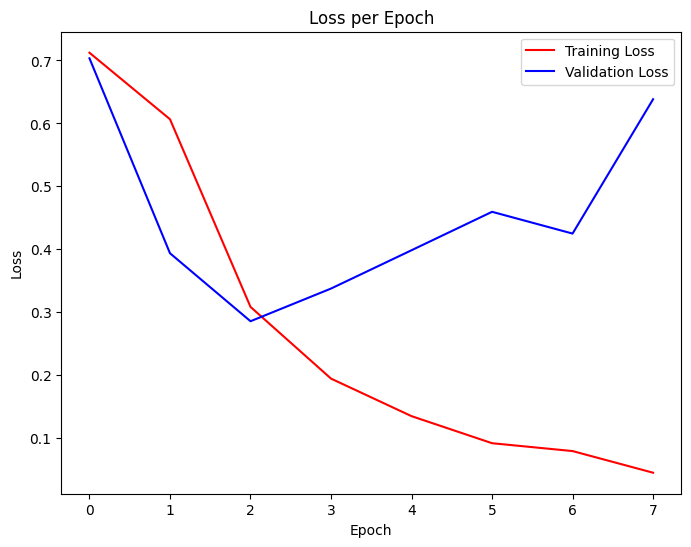

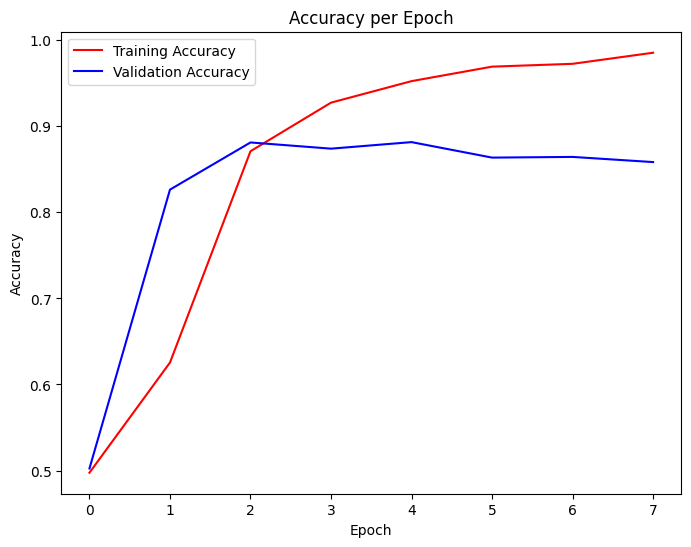

In [109]:
import matplotlib.pyplot as plt

# Loss 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], color='red', label='Training Loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

# Accuracy 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()


이진 분류니까 PR곡선과 ROC곡선을 그려보자.

### PR, ROC 곡선

1/1 [==============================] - 0s 451ms/step


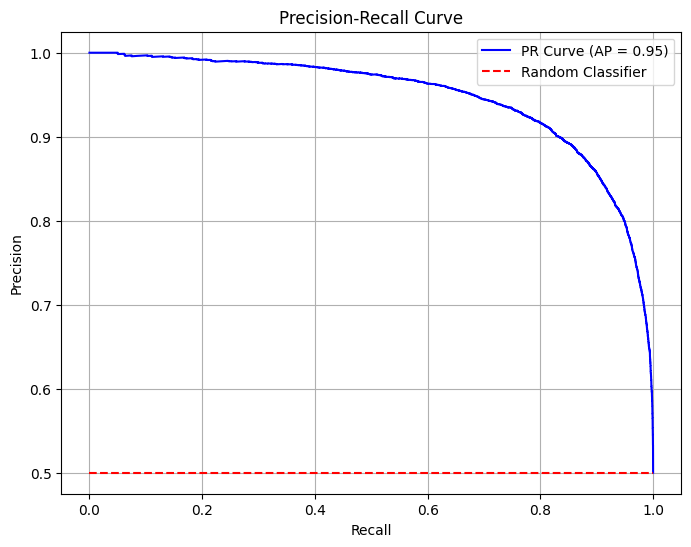

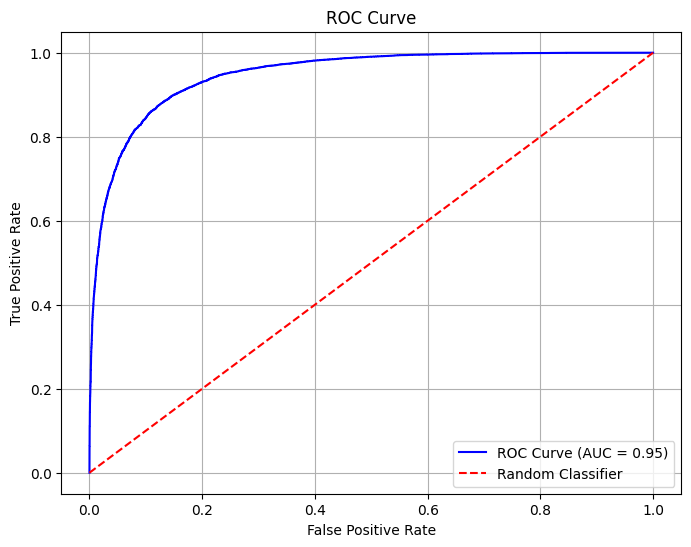

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

# 테스트 셋에서 실제 레이블과 예측 확률 수집하기
y_true = []
y_scores = []
for batch_x, batch_y in test_set:
    preds = model.predict(batch_x)
    # preds가 (batch_size, 1) 형태라면 ravel()로 1차원으로 변환
    y_scores.extend(preds.ravel())
    y_true.extend(batch_y.numpy())
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# 랜덤 분류기의 기준: 테스트셋 내 양성 샘플 비율
baseline = np.mean(y_true)

# =============================
# Precision-Recall Curve 그리기
# =============================
precision, recall, _ = precision_recall_curve(y_true, y_scores)
average_precision = average_precision_score(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR Curve (AP = {average_precision:.2f})')
# 랜덤 분류기의 정밀도는 baseline 값 (수평선)
plt.hlines(baseline, 0, 1, colors='red', linestyles='--', label='Random Classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# =============================
# ROC Curve 그리기
# =============================
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
# 랜덤 분류기의 ROC는 (0,0)에서 (1,1)을 잇는 대각선
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### 임베딩 공간 시각화

In [199]:
model.load_weights("encoder_model2.keras") # 저장된 모델의 가중치만 불러와서 덮어 씌운다. TextVectorization층에 넣은 사용자 정의 전처리 함수에 @tf.keras.utils.register_keras_serializable(package='Custom') 데코레이터를 붙이지 않아서 모델이 불러와지지 않는 것 때문에 곤란하던 참인데 이런 방법이 생김.

In [200]:
vocab = text_vec_layer.get_vocabulary()
print(vocab[:10])


['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']


In [202]:
import os
import tensorflow as tf
from tensorboard.plugins import projector

# 로그 디렉토리 설정
log_dir = "logs/embedding"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# 어휘 사전 생성 (예시)
vocab = text_vec_layer.get_vocabulary()

# metadata 파일 생성
metadata_file = os.path.join(log_dir, "metadata.tsv")
with open(metadata_file, "w", encoding="utf-8") as f:
    for word in vocab:
        f.write(word + "\n")

# 임베딩 레이어 생성 (이름이 'token_embedding'으로 지정됨)
embedding_layer = model.get_layer('embedding_5')

# 임베딩 레이어 가중치 체크포인트 저장
checkpoint = tf.train.Checkpoint(embedding=embedding_layer)
checkpoint_path = os.path.join(log_dir, "embedding.ckpt")
checkpoint.save(checkpoint_path)

# TensorBoard Projector 설정
config = projector.ProjectorConfig()
embedding_config = config.embeddings.add()
embedding_config.tensor_name = "token_embedding/embeddings:0"
embedding_config.metadata_path = "metadata.tsv"  # 로그 디렉토리 기준 상대 경로

projector.visualize_embeddings(log_dir, config)

print("TensorBoard Projector 설정 완료. 'logs/embedding' 경로를 확인하세요.")

TensorBoard Projector 설정 완료. 'logs/embedding' 경로를 확인하세요.


Projections 탭으로 가서 시각화 결과를 확인할 수 있다.

주피터 노트북 상에서 텐서보드가 실행이 안되면 그냥 터미널에 `tensorboard --logdir=logs/embedding`를 입력 하면 된다. 로컬 호스트 6006포트로 접속하면 됨.

모델이.... 잘 훈련되지 않음... 테스트 정확도가 0.5정도로 나오는데, binary cross entrophy의 경우 아래와 같은 방식으로 작동한다.

<img src="image/Screenshot 2025-02-22 at 4.17.53 PM.png" width="400"/>

모델은 지금 무작위 선택보다 조금 나은 수준이다. 훈련을 진행할 수록 훈련 손실은 감소하고, 정확도는 증가하고 있는데, 검증은 제자리이거나 오히려 나빠지고 있다. 모델이 심하게 과적합되었음.

그리고 훈련을 진행하는 과정 자체에도 어려움이 많았음. 처음에는 지수기반 스케줄링과 성능기반 스케줄링을 같이 사용했는데, 학습률을 너무 빨리 줄여버리는게 문제였음.
그래서 지금 코드의 학습률 웜업과 지수기반 스케줄링을 같이 사용하는 방식을 씀.

그리고 배치 수도 문제였다. 배치 크기를 늘리면 훈련이 빨리 될거라고 생각해서 배치 크기를 무식하게 512까지 늘렸더니 램이 꽉차면서 맥이 뻗어버림ㅋㅋ
그래서 다시 128로 줄이고 모델 훈련을 돌렸으나, 모델이 제대로 훈련되지 않음. 다시 원래의 32로 줄여서 훈련시키니까 제대로 훈련되기 시작함.
RNN때는 배치 크기를 늘리는 것이 훈련 시간을 단축하는데 꽤 큰 효과를 보였으나, 트랜스포머에서는 별로 그렇지 않은 것처럼 보임. 이에 대한 탐구가 필요해보임.

그래서 과적합 문제를 해결해야 하는데, 고려해 볼 수 있는 옵션으로는 멀티 헤드 어텐션 층의 헤드 수를 줄이고, FFN층의 뉴런수를 감소시키고, 드롭 아웃 비율을 증가시키는 것 등이 있다.
일단 세가지 옵션을 다 사용해서 모델의 파라미터 수를 줄여보자.

그리고 현재 모델이 제대로 작동하고 있는지에 대한 의구심도 좀 들기 시작한다. CLS토큰을 사용하는 방식이 정말 제대로 작동하고 있는 것인지, 패딩 토큰 마스킹이 제대로 작동되고 있는지 등등의 검증이 필요해보인다.

### 예측

In [139]:
model.predict(["I don't know"])

1/1 [==============================] - 0s 91ms/step


array([[0.27697182]], dtype=float32)